#### Evaluation and Visualisation of Results on PLAsTiCC with `t2` + Z feats, trained on `avocado` Augmented Data

In [1]:
import argparse
import joblib
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import seaborn as sns
import tensorflow as tf

from itertools import cycle
from numpy import interp
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from tensorflow import keras

from astronet.constants import astronet_working_directory as asnwd
from astronet.preprocess import one_hot_encode
from astronet.utils import astronet_logger, load_dataset

In [2]:
from astronet.metrics import WeightedLogLoss
from astronet.visualise_results import plot_acc_history, plot_confusion_matrix, plot_loss_history, plot_multiROC

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import random as python_random
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(RANDOM_SEED)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"]})

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [4]:
mpl.style.use("seaborn-whitegrid")

In [5]:
architecture = "t2"

In [6]:
dataset = "plasticc"

In [7]:
X_train, y_train, X_test, y_test, loss, Z_train, Z_test = load_dataset(dataset, redshift=True, augmented=None)

In [8]:
num_classes = y_train.shape[1]
num_classes

14

In [11]:
import pandas as pd

In [13]:
adf_meta = pd.read_csv(f"{asnwd}/data/plasticc/avocado/avo_aug_0.csv")
adf_meta.head()

,object_id,augment_brightness,class,ddf,decl,galactic,host_photoz,host_photoz_error,host_specz,libid_cadence,...,tflux_u,tflux_y,tflux_z,true_av,true_distmod,true_lensdmu,true_peakmjd,true_rv,true_submodel,true_vpec
0,plasticc_000000615,NaN,92,True,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
1,plasticc_000000615_aug_AzxESpYoJo,0.524115,92,True,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
2,plasticc_000000615_aug_BQnUUMWIRV,1.236675,92,False,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
3,plasticc_000000615_aug_BZJNKLoZJj,-0.505715,92,False,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
4,plasticc_000000615_aug_BcxZIXlnyy,-0.239368,92,False,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0


In [24]:
adf_meta.shape

(591410, 27)

In [33]:
adf = pd.read_csv(f"{asnwd}/data/plasticc/avocado/avo_aug_1_chunk_0.csv")
adf.head()

,Unnamed: 0,Unnamed: 0.1,object_id,time,flux,flux_error,detected,band,reference_time,model_flux,model_flux_error
0,24,0,plasticc_000014156,59825.2600,-0.356823,1.901826,0,lsstr,NaN,NaN,NaN
1,32,0,plasticc_000026783,59582.3282,-196.574493,4.877807,1,lsstu,NaN,NaN,NaN
2,50,0,plasticc_000000615,59750.4229,-544.810303,3.622952,1,lsstr,NaN,NaN,NaN
3,66,0,plasticc_000041738,59582.3282,2.267234,2.797876,0,lsstu,NaN,NaN,NaN
4,72,0,plasticc_000055155,59798.3205,-53.350220,1.486681,1,lsstr,NaN,NaN,NaN


In [20]:
adf.tail()

,Unnamed: 0,Unnamed: 0.1,object_id,time,flux,flux_error,detected,band,reference_time,model_flux,model_flux_error
1523727,30551652,305516,plasticc_000004595_aug_xISBcxFqYR,60584.725130,-0.451183,3.057167,0,lsstg,60580.0173,0.526060,1.143627
1523728,30551655,305516,plasticc_000031100_aug_myoDPPJMfa,60602.555161,0.616149,4.352540,0,lssti,60580.0724,-0.273872,0.318235
1523729,30551666,305516,plasticc_000045115_aug_PpzabQpPHU,59776.727124,0.965632,1.554039,0,lsstr,59770.3662,0.744796,0.459376
1523730,30551692,305516,plasticc_000017172_aug_SOgJxpexyQ,60340.600218,40.439573,24.716463,0,lsstz,60300.1031,2.622992,3.381020
1523731,30551713,305517,plasticc_000031100_aug_myoDPPJMfa,60604.892265,-19.312346,11.469265,0,lsstu,60582.0718,-0.535134,0.537205


In [15]:
training_set = pd.read_csv(f"{asnwd}/data/plasticc/training_set.csv")
training_set.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [19]:
metadata = pd.read_csv(f"{asnwd}/data/plasticc/training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [21]:
trans = pd.read_csv(f"{asnwd}/data/plasticc/full_transformed_df_timesteps_100_with_z.csv")
trans.head()

,Unnamed: 0,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,hostgal_photoz,hostgal_photoz_err,target
0,0,0.000000,-814.732313,-470.080742,-544.981770,-956.116578,-319.461066,-388.215883,615,0.0,0.0,92
1,1,8.826165,-128.566904,-110.479797,-120.278512,-132.620444,-91.900141,-100.917286,615,0.0,0.0,92
2,2,17.652329,-841.636823,-501.647918,-624.017111,-962.126994,-438.189832,-446.451725,615,0.0,0.0,92
3,3,26.478494,-580.554089,-430.941104,-504.457618,-618.868227,-337.092959,-376.440402,615,0.0,0.0,92
4,4,35.304659,-129.369677,-115.540645,-119.944191,-137.870701,-115.465553,-114.915909,615,0.0,0.0,92


In [54]:
adf.tail()

,Unnamed: 0,Unnamed: 0.1,object_id,mjd,flux,flux_error,detected,filter,reference_time,model_flux,model_flux_error
1523727,30551652,305516,plasticc_000004595_aug_xISBcxFqYR,60584.725130,-0.451183,3.057167,0,lsstg,60580.0173,0.526060,1.143627
1523728,30551655,305516,plasticc_000031100_aug_myoDPPJMfa,60602.555161,0.616149,4.352540,0,lssti,60580.0724,-0.273872,0.318235
1523729,30551666,305516,plasticc_000045115_aug_PpzabQpPHU,59776.727124,0.965632,1.554039,0,lsstr,59770.3662,0.744796,0.459376
1523730,30551692,305516,plasticc_000017172_aug_SOgJxpexyQ,60340.600218,40.439573,24.716463,0,lsstz,60300.1031,2.622992,3.381020
1523731,30551713,305517,plasticc_000031100_aug_myoDPPJMfa,60604.892265,-19.312346,11.469265,0,lsstu,60582.0718,-0.535134,0.537205


In [36]:
adf.rename(
        {"band": "filter"}, axis="columns", inplace=True
    )
adf.rename(
        {"time": "mjd"}, axis="columns", inplace=True
    )

In [56]:
df = adf
df.tail()

,Unnamed: 0,Unnamed: 0.1,object_id,mjd,flux,flux_error,detected,filter,reference_time,model_flux,model_flux_error
1523727,30551652,305516,plasticc_000004595_aug_xISBcxFqYR,60584.725130,-0.451183,3.057167,0,lsstg,60580.0173,0.526060,1.143627
1523728,30551655,305516,plasticc_000031100_aug_myoDPPJMfa,60602.555161,0.616149,4.352540,0,lssti,60580.0724,-0.273872,0.318235
1523729,30551666,305516,plasticc_000045115_aug_PpzabQpPHU,59776.727124,0.965632,1.554039,0,lsstr,59770.3662,0.744796,0.459376
1523730,30551692,305516,plasticc_000017172_aug_SOgJxpexyQ,60340.600218,40.439573,24.716463,0,lsstz,60300.1031,2.622992,3.381020
1523731,30551713,305517,plasticc_000031100_aug_myoDPPJMfa,60604.892265,-19.312346,11.469265,0,lsstu,60582.0718,-0.535134,0.537205


In [ ]:
"plasticc_000031100_aug_myoDPPJMfa"

In [38]:
object_list = list(np.unique(df['object_id']))

In [67]:
object_list = object_list[:9]

In [68]:
len(object_list)

9

In [69]:
from astronet.utils import __transient_trim, __generate_gp_all_objects

In [70]:
timesteps = 100

In [71]:
obs_transient = __transient_trim(object_list, df)
generated_gp_dataset = __generate_gp_all_objects(object_list, obs_transient, timesteps)
# generated_gp_dataset['object_id'] = generated_gp_dataset['object_id'].astype(int)

In [72]:
generated_gp_dataset['object_id'][0] == generated_gp_dataset['object_id'][0] 

True

In [73]:
metadata_pd = pd.read_csv(
    f"{asnwd}/data/plasticc/avocado/avo_aug_0.csv",
    sep=",",
    index_col="object_id",
)

In [74]:
metadata_pd.head()

,augment_brightness,class,ddf,decl,galactic,host_photoz,host_photoz_error,host_specz,libid_cadence,mwebv,...,tflux_u,tflux_y,tflux_z,true_av,true_distmod,true_lensdmu,true_peakmjd,true_rv,true_submodel,true_vpec
object_id,,,,,,,,,,,,,,,,,,,,,
plasticc_000000615,NaN,92,True,-61.9438,True,0.0,0.0,0.0,69,0.017000,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
plasticc_000000615_aug_AzxESpYoJo,0.524115,92,True,-61.9438,True,0.0,0.0,0.0,69,0.015274,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
plasticc_000000615_aug_BQnUUMWIRV,1.236675,92,False,-61.9438,True,0.0,0.0,0.0,69,0.014330,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
plasticc_000000615_aug_BZJNKLoZJj,-0.505715,92,False,-61.9438,True,0.0,0.0,0.0,69,0.015506,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
plasticc_000000615_aug_BcxZIXlnyy,-0.239368,92,False,-61.9438,True,0.0,0.0,0.0,69,0.016906,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0


In [75]:
metadata_pd = metadata_pd.reset_index()
metadata_pd.head()

,object_id,augment_brightness,class,ddf,decl,galactic,host_photoz,host_photoz_error,host_specz,libid_cadence,...,tflux_u,tflux_y,tflux_z,true_av,true_distmod,true_lensdmu,true_peakmjd,true_rv,true_submodel,true_vpec
0,plasticc_000000615,NaN,92,True,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
1,plasticc_000000615_aug_AzxESpYoJo,0.524115,92,True,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
2,plasticc_000000615_aug_BQnUUMWIRV,1.236675,92,False,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
3,plasticc_000000615_aug_BZJNKLoZJj,-0.505715,92,False,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
4,plasticc_000000615_aug_BcxZIXlnyy,-0.239368,92,False,-61.9438,True,0.0,0.0,0.0,69,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0


In [95]:
df_with_labels = generated_gp_dataset.merge(metadata_pd, on='object_id', how='left')
df_with_labels.head()

,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,augment_brightness,class,...,tflux_u,tflux_y,tflux_z,true_av,true_distmod,true_lensdmu,true_peakmjd,true_rv,true_submodel,true_vpec
0,0,-814.732,-470.081,-544.982,-956.117,-319.461,-388.216,plasticc_000000615,NaN,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
1,8.82616,-128.567,-110.48,-120.279,-132.62,-91.9001,-100.917,plasticc_000000615,NaN,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
2,17.6523,-841.637,-501.648,-624.017,-962.127,-438.19,-446.452,plasticc_000000615,NaN,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
3,26.4785,-580.554,-430.941,-504.458,-618.868,-337.093,-376.44,plasticc_000000615,NaN,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
4,35.3047,-129.37,-115.541,-119.944,-137.871,-115.466,-114.916,plasticc_000000615,NaN,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0


In [96]:
df_with_labels.tail()

,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,augment_brightness,class,...,tflux_u,tflux_y,tflux_z,true_av,true_distmod,true_lensdmu,true_peakmjd,true_rv,true_submodel,true_vpec
895,835.569,-19.6907,-15.4513,-17.8423,-20.2092,-11.143,-13.1736,plasticc_000000615_aug_FpnrMOqvLU,1.413341,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
896,844.364,31.6524,5.0499,19.1976,37.6166,-15.4837,-6.82225,plasticc_000000615_aug_FpnrMOqvLU,1.413341,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
897,853.16,57.4078,75.3957,67.427,49.573,80.4637,79.8481,plasticc_000000615_aug_FpnrMOqvLU,1.413341,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
898,861.955,-8.03098,-6.61094,-7.45255,-8.13659,-4.95326,-5.753,plasticc_000000615_aug_FpnrMOqvLU,1.413341,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0
899,870.751,64.4211,65.0288,68.8735,57.3439,50.4036,57.9218,plasticc_000000615_aug_FpnrMOqvLU,1.413341,92,...,484.7,2837.0,2854.5,0.0,0.0,0.0,59570.0,0.0,1,0.0


In [97]:
df_with_labels.shape

(900, 34)

In [98]:
df_with_labels.rename(
        {"class": "target"}, axis="columns", inplace=True
    )
df_with_labels.rename(
        {"host_photoz": "hostgal_photoz"}, axis="columns", inplace=True
    )
df_with_labels.rename(
        {"host_photoz_error": "hostgal_photoz_err"}, axis="columns", inplace=True
    )

In [99]:
df = df_with_labels.filter(
    items=[
        "mjd",
        "lsstg",
        "lssti",
        "lsstr",
        "lsstu",
        "lssty",
        "lsstz",
        "object_id",
        "hostgal_photoz",
        "hostgal_photoz_err",
        "target",
        ]
    )


In [100]:
len(np.unique(df['target']))

1

In [102]:
df.tail()

,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,hostgal_photoz,hostgal_photoz_err,target
895,835.569,-19.6907,-15.4513,-17.8423,-20.2092,-11.143,-13.1736,plasticc_000000615_aug_FpnrMOqvLU,0.0,0.0,92
896,844.364,31.6524,5.0499,19.1976,37.6166,-15.4837,-6.82225,plasticc_000000615_aug_FpnrMOqvLU,0.0,0.0,92
897,853.16,57.4078,75.3957,67.427,49.573,80.4637,79.8481,plasticc_000000615_aug_FpnrMOqvLU,0.0,0.0,92
898,861.955,-8.03098,-6.61094,-7.45255,-8.13659,-4.95326,-5.753,plasticc_000000615_aug_FpnrMOqvLU,0.0,0.0,92
899,870.751,64.4211,65.0288,68.8735,57.3439,50.4036,57.9218,plasticc_000000615_aug_FpnrMOqvLU,0.0,0.0,92


In [9]:
model_name = "1613551066-32f3933"
# model_name = "1613501905-d5b52ec"
# model_name = None

with open(f"{asnwd}/astronet/{architecture}/models/{dataset}/results_with_z.json") as f:
    events = json.load(f)
    if model_name is not None:
    # Get params for model chosen with cli args
        event = next(item for item in events['training_result'] if item["name"] == model_name)
    else:
        # Get params for best model with lowest loss
        event = min(
            (item for item in events["training_result"] if item["augmented"] is None),
                key=lambda ev: ev["model_evaluate_on_test_loss"],
            )

#         event = min(events['training_result'], key=lambda ev: ev['model_evaluate_on_test_loss'])

In [10]:
# Show short summary of items in 'event'
dict(list(event.items())[1:4])

{'augmented': None, 'droprate': 0.1, 'embed_dim': 32}

In [11]:
model_name = event['name']
model_name

'1613551066-32f3933'

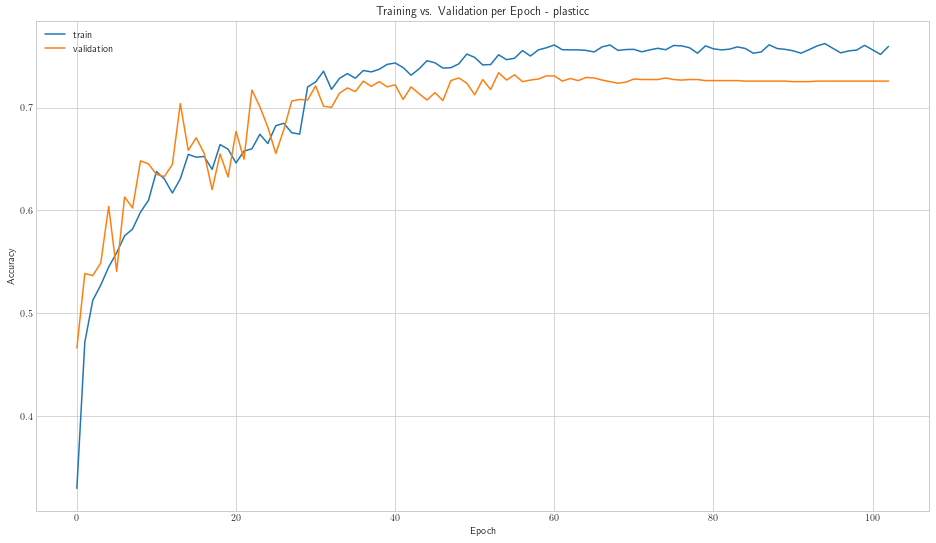

In [12]:
plot_acc_history(dataset, model_name, event, save=False)

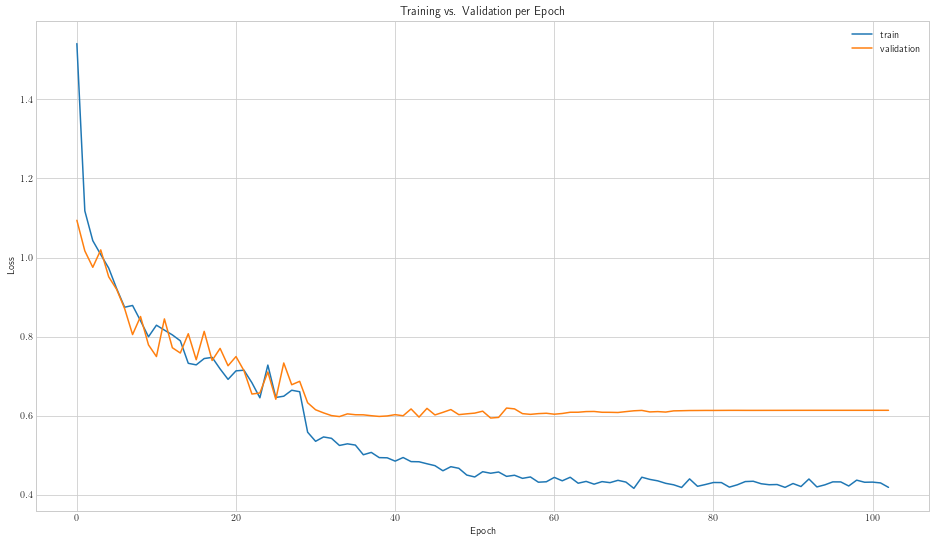

In [13]:
plot_loss_history(dataset, model_name, event, save=False)

In [14]:
model = keras.models.load_model(f"{asnwd}/astronet/{architecture}/models/{dataset}/model-{model_name}", 
                                custom_objects={'WeightedLogLoss': WeightedLogLoss()}, 
                               compile=False)

In [15]:
with open(f"{asnwd}/data/full-{dataset}.encoding", "rb") as eb:
    encoding = joblib.load(eb)
class_encoding = encoding.categories_[0]

if dataset == "plasticc":
    class_mapping = {
        90: "SNIa",
        67: "SNIa-91bg", 
        52: "SNIax",
        42: "SNII",
        62: "SNIbc",
        95: "SLSN-I",
        15: "TDE",
        64: "KN",
        88: "AGN",
        92: "RRL",
        65: "M-dwarf",
        16: "EB",
        53: "Mira",
        6: "$\mu$-Lens-Single",
    }
    class_encoding
    class_names = list(np.vectorize(class_mapping.get)(class_encoding))
else:

    class_names = class_encoding

In [16]:
from collections import Counter
from pandas.core.common import flatten

y_true = encoding.inverse_transform(y_train)
Counter(list(flatten(y_true)))

Counter({95: 126,
         15: 383,
         42: 879,
         90: 1733,
         16: 697,
         65: 735,
         52: 139,
         62: 370,
         67: 161,
         53: 21,
         88: 277,
         92: 183,
         6: 110,
         64: 71})

In [17]:
logloss = event["model_evaluate_on_test_loss"]
acc = event["model_evaluate_on_test_acc"]
print(f"LogLoss on Test Set: {logloss}, Accuracy on Test Set: {acc}")

wloss = WeightedLogLoss()

y_preds = model.predict([X_test, Z_test])
print(f"LL-Test: {wloss(y_test, y_preds).numpy():.2f}")

y_preds_train = model.predict([X_train, Z_train])
print(f"LL-Train: {wloss(y_train, y_preds_train).numpy():.2f}")
# Note the discreptancy seems to be down to inconsistant seeds - see 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

LogLoss on Test Set: 0.6840900182723999, Accuracy on Test Set: 0.7176350951194763
LL-Test: 0.68
LL-Train: 0.44


In [18]:
from astronet.metrics import FlatWeightedLogLoss
fwloss = FlatWeightedLogLoss()

y_preds = model.predict([X_test, Z_test])
print(f"LL-Test: {fwloss(y_test, y_preds).numpy():.2f}")

y_preds_train = model.predict([X_train, Z_train])
print(f"LL-Train: {fwloss(y_train, y_preds_train).numpy():.2f}")
# Note the discreptancy seems to be down to inconsistant seeds - see 
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

LL-Test: 0.81
LL-Train: 0.66


1613551066-32f3933


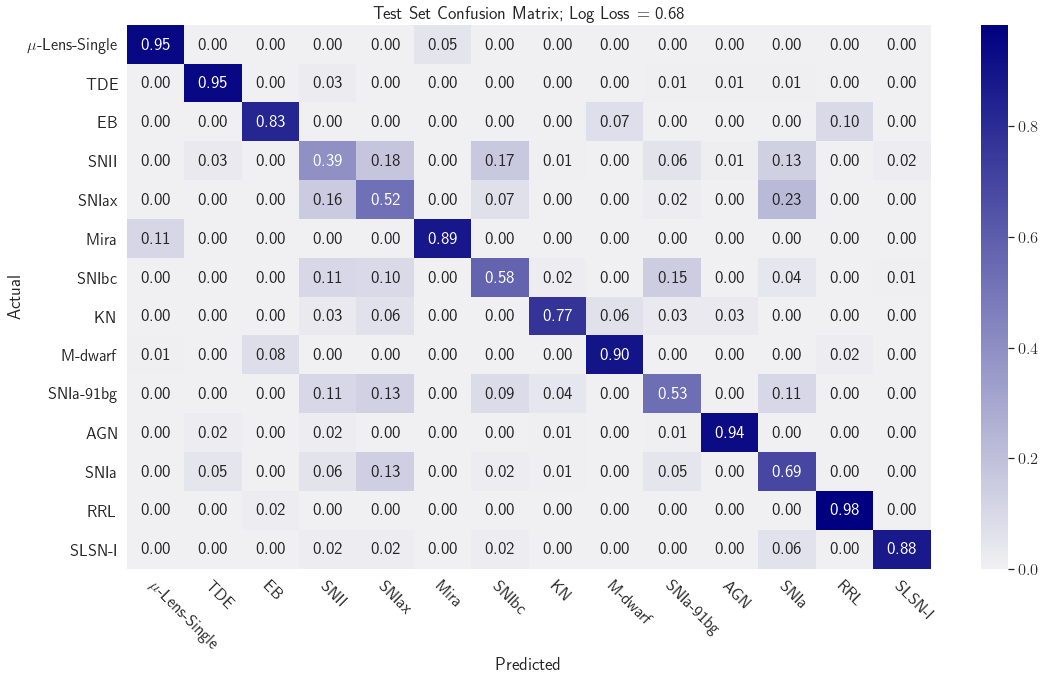

In [19]:
cmap = sns.light_palette("Navy", as_cmap=True)
plot_confusion_matrix(
    dataset,
    model_name,
    y_test,
    y_preds,
    encoding, 
    class_names,  # enc.categories_[0]
    save=False,
    cmap=cmap
)

In [20]:
colors=plt.cm.Accent.colors

1613551066-32f3933


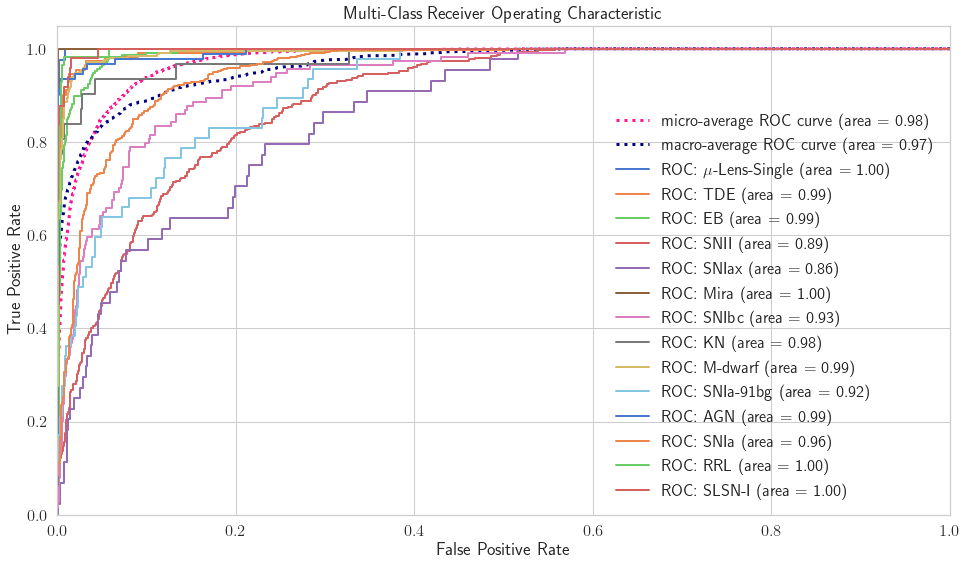

In [21]:
plot_multiROC(dataset, model_name, model, [X_test, Z_test], y_test, class_names, save=False, colors=colors)

## `snmachine` Benchmark Comparisons

As mentioned in https://github.com/tallamjr/astronet/issues/44 one would like to compare performance with the reuslts shown below:
    
<img src="https://user-images.githubusercontent.com/8843728/101194521-04c46800-3656-11eb-9b8c-fc2f30f88cf5.png" width="800">

> The goal would be to compare with the table below, specifically **LL_test**, with and without redshift (**z**) information:

From the results obtained for the `t2` model, a weighted log-loss score of $$LL_{test} = 0.68$$ as well as $$LL_{train} = 0.44$$

The AUC measurements for $AUC_{test}$ only, since we have only evaluated on the test set are: <br>
$$AUC_{test}SNIa = 0.96$$

# Evaluatate on Full Test Set

#### Load first batch file

In [46]:
X_full_test = np.load(
        f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_test_plasticc_test_lightcurves_01.npy",
)    

In [47]:
batch_filename = [
    "plasticc_test_lightcurves_02_chunk_0",
    "plasticc_test_lightcurves_02_chunk_1",
    "plasticc_test_lightcurves_02_chunk_2",
    "plasticc_test_lightcurves_02_chunk_3",
    "plasticc_test_lightcurves_02_chunk_4",
    "plasticc_test_lightcurves_02_chunk_5",
    "plasticc_test_lightcurves_02_chunk_6",
    "plasticc_test_lightcurves_02_chunk_7",
    "plasticc_test_lightcurves_02_chunk_8",
    "plasticc_test_lightcurves_02_chunk_9",
#     "plasticc_test_lightcurves_02_chunk_10", # missing ?
    "plasticc_test_lightcurves_02_chunk_11",
    "plasticc_test_lightcurves_02_chunk_12",
    "plasticc_test_lightcurves_02_chunk_13",
    "plasticc_test_lightcurves_02_chunk_14",
    "plasticc_test_lightcurves_02_chunk_15",
    "plasticc_test_lightcurves_02_chunk_16",
    "plasticc_test_lightcurves_02_chunk_17",
    "plasticc_test_lightcurves_02_chunk_18",
    "plasticc_test_lightcurves_02_chunk_19",
    "plasticc_test_lightcurves_02_chunk_20",
    "plasticc_test_lightcurves_02_chunk_21",
    "plasticc_test_lightcurves_02_chunk_22",
    "plasticc_test_lightcurves_02_chunk_23",
    "plasticc_test_lightcurves_02_chunk_24",
    "plasticc_test_lightcurves_02_chunk_25",
    "plasticc_test_lightcurves_02_chunk_26",
    "plasticc_test_lightcurves_02_chunk_27",
    "plasticc_test_lightcurves_02_chunk_28",
    "plasticc_test_lightcurves_02_chunk_29",
    "plasticc_test_lightcurves_02_chunk_30",
    "plasticc_test_lightcurves_02_chunk_31",
    "plasticc_test_lightcurves_02_chunk_32",
    "plasticc_test_lightcurves_02_chunk_33",
    "plasticc_test_lightcurves_02_chunk_34",
    "plasticc_test_lightcurves_03_chunk_0",
    "plasticc_test_lightcurves_03_chunk_1",
    "plasticc_test_lightcurves_03_chunk_2",
    "plasticc_test_lightcurves_03_chunk_3",
    "plasticc_test_lightcurves_03_chunk_4",
    "plasticc_test_lightcurves_03_chunk_5",
    "plasticc_test_lightcurves_03_chunk_6",
    "plasticc_test_lightcurves_03_chunk_7",
    "plasticc_test_lightcurves_03_chunk_8",
    "plasticc_test_lightcurves_03_chunk_9",
    "plasticc_test_lightcurves_03_chunk_10",
    "plasticc_test_lightcurves_03_chunk_11",
    "plasticc_test_lightcurves_03_chunk_12",
    "plasticc_test_lightcurves_03_chunk_13",
    "plasticc_test_lightcurves_03_chunk_14",
    "plasticc_test_lightcurves_03_chunk_15",
    "plasticc_test_lightcurves_03_chunk_16",
    "plasticc_test_lightcurves_03_chunk_17",
    "plasticc_test_lightcurves_03_chunk_18",
    "plasticc_test_lightcurves_03_chunk_19",
    "plasticc_test_lightcurves_03_chunk_20",
    "plasticc_test_lightcurves_03_chunk_21",
    "plasticc_test_lightcurves_03_chunk_22",
    "plasticc_test_lightcurves_03_chunk_23",
    "plasticc_test_lightcurves_03_chunk_24",
    "plasticc_test_lightcurves_03_chunk_25",
    "plasticc_test_lightcurves_03_chunk_26",
    "plasticc_test_lightcurves_03_chunk_27",
    "plasticc_test_lightcurves_03_chunk_28",
    "plasticc_test_lightcurves_03_chunk_29",
    "plasticc_test_lightcurves_03_chunk_30",
    "plasticc_test_lightcurves_03_chunk_31",
    "plasticc_test_lightcurves_03_chunk_32",
    "plasticc_test_lightcurves_03_chunk_33",
    "plasticc_test_lightcurves_03_chunk_34",
    "plasticc_test_lightcurves_04_chunk_0",
    "plasticc_test_lightcurves_04_chunk_1",
    "plasticc_test_lightcurves_04_chunk_2",
    "plasticc_test_lightcurves_04_chunk_3",
    "plasticc_test_lightcurves_04_chunk_4",
    "plasticc_test_lightcurves_04_chunk_5",
    "plasticc_test_lightcurves_04_chunk_6",
    "plasticc_test_lightcurves_04_chunk_7",
    "plasticc_test_lightcurves_04_chunk_8",
    "plasticc_test_lightcurves_04_chunk_9",
    "plasticc_test_lightcurves_04_chunk_10",
    "plasticc_test_lightcurves_04_chunk_11",
    "plasticc_test_lightcurves_04_chunk_12",
    "plasticc_test_lightcurves_04_chunk_13",
    "plasticc_test_lightcurves_04_chunk_14",
    "plasticc_test_lightcurves_04_chunk_15",
    "plasticc_test_lightcurves_04_chunk_16",
    "plasticc_test_lightcurves_04_chunk_17",
    "plasticc_test_lightcurves_04_chunk_18",
    "plasticc_test_lightcurves_04_chunk_19",
    "plasticc_test_lightcurves_04_chunk_20",
    "plasticc_test_lightcurves_04_chunk_21",
    "plasticc_test_lightcurves_04_chunk_22",
    "plasticc_test_lightcurves_04_chunk_23",
    "plasticc_test_lightcurves_04_chunk_24",
    "plasticc_test_lightcurves_04_chunk_25",
    "plasticc_test_lightcurves_04_chunk_26",
    "plasticc_test_lightcurves_04_chunk_27",
    "plasticc_test_lightcurves_04_chunk_28",
    "plasticc_test_lightcurves_04_chunk_29",
    "plasticc_test_lightcurves_04_chunk_30",
    "plasticc_test_lightcurves_04_chunk_31",
    "plasticc_test_lightcurves_04_chunk_32",
    "plasticc_test_lightcurves_04_chunk_33",
    "plasticc_test_lightcurves_04_chunk_34",
    "plasticc_test_lightcurves_05_chunk_0",
    "plasticc_test_lightcurves_05_chunk_1",
    "plasticc_test_lightcurves_05_chunk_2",
    "plasticc_test_lightcurves_05_chunk_3",
    "plasticc_test_lightcurves_05_chunk_4",
    "plasticc_test_lightcurves_05_chunk_5",
    "plasticc_test_lightcurves_05_chunk_6",
    "plasticc_test_lightcurves_05_chunk_7",
    "plasticc_test_lightcurves_05_chunk_8",
    "plasticc_test_lightcurves_05_chunk_9",
    "plasticc_test_lightcurves_05_chunk_10",
    "plasticc_test_lightcurves_05_chunk_11",
    "plasticc_test_lightcurves_05_chunk_12",
    "plasticc_test_lightcurves_05_chunk_13",
    "plasticc_test_lightcurves_05_chunk_14",
    "plasticc_test_lightcurves_05_chunk_15",
    "plasticc_test_lightcurves_05_chunk_16",
    "plasticc_test_lightcurves_05_chunk_17",
    "plasticc_test_lightcurves_05_chunk_18",
    "plasticc_test_lightcurves_05_chunk_19",
    "plasticc_test_lightcurves_05_chunk_20",
    "plasticc_test_lightcurves_05_chunk_21",
    "plasticc_test_lightcurves_05_chunk_22",
    "plasticc_test_lightcurves_05_chunk_23",
    "plasticc_test_lightcurves_05_chunk_24",
    "plasticc_test_lightcurves_05_chunk_25",
    "plasticc_test_lightcurves_05_chunk_26",
    "plasticc_test_lightcurves_05_chunk_27",
    "plasticc_test_lightcurves_05_chunk_28",
    "plasticc_test_lightcurves_05_chunk_29",
    "plasticc_test_lightcurves_05_chunk_30",
    "plasticc_test_lightcurves_05_chunk_31",
    "plasticc_test_lightcurves_05_chunk_32",
    "plasticc_test_lightcurves_05_chunk_33",
    "plasticc_test_lightcurves_05_chunk_34",
    "plasticc_test_lightcurves_06_chunk_0",
    "plasticc_test_lightcurves_06_chunk_1",
    "plasticc_test_lightcurves_06_chunk_2",
    "plasticc_test_lightcurves_06_chunk_3",
    "plasticc_test_lightcurves_06_chunk_4",
    "plasticc_test_lightcurves_06_chunk_5",
    "plasticc_test_lightcurves_06_chunk_6",
    "plasticc_test_lightcurves_06_chunk_7",
    "plasticc_test_lightcurves_06_chunk_8",
    "plasticc_test_lightcurves_06_chunk_9",
    "plasticc_test_lightcurves_06_chunk_10",
    "plasticc_test_lightcurves_06_chunk_11",
    "plasticc_test_lightcurves_06_chunk_12",
    "plasticc_test_lightcurves_06_chunk_13",
    "plasticc_test_lightcurves_06_chunk_14",
    "plasticc_test_lightcurves_06_chunk_15",
    "plasticc_test_lightcurves_06_chunk_16",
    "plasticc_test_lightcurves_06_chunk_17",
    "plasticc_test_lightcurves_06_chunk_18",
    "plasticc_test_lightcurves_06_chunk_19",
    "plasticc_test_lightcurves_06_chunk_20",
    "plasticc_test_lightcurves_06_chunk_21",
    "plasticc_test_lightcurves_06_chunk_22",
    "plasticc_test_lightcurves_06_chunk_23",
    "plasticc_test_lightcurves_06_chunk_24",
    "plasticc_test_lightcurves_06_chunk_25",
    "plasticc_test_lightcurves_06_chunk_26",
    "plasticc_test_lightcurves_06_chunk_27",
    "plasticc_test_lightcurves_06_chunk_28",
    "plasticc_test_lightcurves_06_chunk_29",
    "plasticc_test_lightcurves_06_chunk_30",
    "plasticc_test_lightcurves_06_chunk_31",
    "plasticc_test_lightcurves_06_chunk_32",
    "plasticc_test_lightcurves_06_chunk_33",
    "plasticc_test_lightcurves_06_chunk_34",
    "plasticc_test_lightcurves_07_chunk_0",
    "plasticc_test_lightcurves_07_chunk_1",
    "plasticc_test_lightcurves_07_chunk_2",
    "plasticc_test_lightcurves_07_chunk_3",
    "plasticc_test_lightcurves_07_chunk_4",
    "plasticc_test_lightcurves_07_chunk_5",
    "plasticc_test_lightcurves_07_chunk_6",
    "plasticc_test_lightcurves_07_chunk_7",
    "plasticc_test_lightcurves_07_chunk_8",
    "plasticc_test_lightcurves_07_chunk_9",
    "plasticc_test_lightcurves_07_chunk_10",
    "plasticc_test_lightcurves_07_chunk_11",
    "plasticc_test_lightcurves_07_chunk_12",
    "plasticc_test_lightcurves_07_chunk_13",
    "plasticc_test_lightcurves_07_chunk_14",
    "plasticc_test_lightcurves_07_chunk_15",
    "plasticc_test_lightcurves_07_chunk_16",
    "plasticc_test_lightcurves_07_chunk_17",
    "plasticc_test_lightcurves_07_chunk_18",
    "plasticc_test_lightcurves_07_chunk_19",
    "plasticc_test_lightcurves_07_chunk_20",
    "plasticc_test_lightcurves_07_chunk_21",
    "plasticc_test_lightcurves_07_chunk_22",
    "plasticc_test_lightcurves_07_chunk_23",
    "plasticc_test_lightcurves_07_chunk_24",
    "plasticc_test_lightcurves_07_chunk_25",
    "plasticc_test_lightcurves_07_chunk_26",
    "plasticc_test_lightcurves_07_chunk_27",
    "plasticc_test_lightcurves_07_chunk_28",
    "plasticc_test_lightcurves_07_chunk_29",
    "plasticc_test_lightcurves_07_chunk_30",
    "plasticc_test_lightcurves_07_chunk_31",
    "plasticc_test_lightcurves_07_chunk_32",
    "plasticc_test_lightcurves_07_chunk_33",
    "plasticc_test_lightcurves_07_chunk_34",
    "plasticc_test_lightcurves_08_chunk_0",
    "plasticc_test_lightcurves_08_chunk_1",
    "plasticc_test_lightcurves_08_chunk_2",
    "plasticc_test_lightcurves_08_chunk_3",
    "plasticc_test_lightcurves_08_chunk_4",
    "plasticc_test_lightcurves_08_chunk_5",
    "plasticc_test_lightcurves_08_chunk_6",
    "plasticc_test_lightcurves_08_chunk_7",
    "plasticc_test_lightcurves_08_chunk_8",
    "plasticc_test_lightcurves_08_chunk_9",
    "plasticc_test_lightcurves_08_chunk_10",
    "plasticc_test_lightcurves_08_chunk_11",
    "plasticc_test_lightcurves_08_chunk_12",
    "plasticc_test_lightcurves_08_chunk_13",
    "plasticc_test_lightcurves_08_chunk_14",
    "plasticc_test_lightcurves_08_chunk_15",
    "plasticc_test_lightcurves_08_chunk_16",
    "plasticc_test_lightcurves_08_chunk_17",
    "plasticc_test_lightcurves_08_chunk_18",
    "plasticc_test_lightcurves_08_chunk_19",
    "plasticc_test_lightcurves_08_chunk_20",
    "plasticc_test_lightcurves_08_chunk_21",
    "plasticc_test_lightcurves_08_chunk_22",
    "plasticc_test_lightcurves_08_chunk_23",
    "plasticc_test_lightcurves_08_chunk_24",
    "plasticc_test_lightcurves_08_chunk_25",
    "plasticc_test_lightcurves_08_chunk_26",
    "plasticc_test_lightcurves_08_chunk_27",
    "plasticc_test_lightcurves_08_chunk_28",
    "plasticc_test_lightcurves_08_chunk_29",
    "plasticc_test_lightcurves_08_chunk_30",
    "plasticc_test_lightcurves_08_chunk_31",
    "plasticc_test_lightcurves_08_chunk_32",
    "plasticc_test_lightcurves_08_chunk_33",
    "plasticc_test_lightcurves_08_chunk_34",
    "plasticc_test_lightcurves_09_chunk_0",
    "plasticc_test_lightcurves_09_chunk_1",
    "plasticc_test_lightcurves_09_chunk_2",
    "plasticc_test_lightcurves_09_chunk_3",
    "plasticc_test_lightcurves_09_chunk_4",
    "plasticc_test_lightcurves_09_chunk_5",
    "plasticc_test_lightcurves_09_chunk_6",
    "plasticc_test_lightcurves_09_chunk_7",
    "plasticc_test_lightcurves_09_chunk_8",
#     "plasticc_test_lightcurves_09_chunk_9", # missing ?
    "plasticc_test_lightcurves_09_chunk_10",
    "plasticc_test_lightcurves_09_chunk_11",
    "plasticc_test_lightcurves_09_chunk_12",
    "plasticc_test_lightcurves_09_chunk_13",
    "plasticc_test_lightcurves_09_chunk_14",
    "plasticc_test_lightcurves_09_chunk_15",
    "plasticc_test_lightcurves_09_chunk_16",
    "plasticc_test_lightcurves_09_chunk_17",
    "plasticc_test_lightcurves_09_chunk_18",
    "plasticc_test_lightcurves_09_chunk_19",
    "plasticc_test_lightcurves_09_chunk_20",
    "plasticc_test_lightcurves_09_chunk_21",
    "plasticc_test_lightcurves_09_chunk_22",
    "plasticc_test_lightcurves_09_chunk_23",
    "plasticc_test_lightcurves_09_chunk_24",
    "plasticc_test_lightcurves_09_chunk_25",
    "plasticc_test_lightcurves_09_chunk_26",
    "plasticc_test_lightcurves_09_chunk_27",
    "plasticc_test_lightcurves_09_chunk_28",
    "plasticc_test_lightcurves_09_chunk_29",
    "plasticc_test_lightcurves_09_chunk_30",
    "plasticc_test_lightcurves_09_chunk_31",
    "plasticc_test_lightcurves_09_chunk_32",
    "plasticc_test_lightcurves_09_chunk_33",
    "plasticc_test_lightcurves_09_chunk_34",
    "plasticc_test_lightcurves_10_chunk_0",
    "plasticc_test_lightcurves_10_chunk_1",
    "plasticc_test_lightcurves_10_chunk_2",
    "plasticc_test_lightcurves_10_chunk_3",
    "plasticc_test_lightcurves_10_chunk_4",
    "plasticc_test_lightcurves_10_chunk_5",
    "plasticc_test_lightcurves_10_chunk_6",
    "plasticc_test_lightcurves_10_chunk_7",
    "plasticc_test_lightcurves_10_chunk_8",
    "plasticc_test_lightcurves_10_chunk_9",
    "plasticc_test_lightcurves_10_chunk_10",
    "plasticc_test_lightcurves_10_chunk_11",
    "plasticc_test_lightcurves_10_chunk_12",
    "plasticc_test_lightcurves_10_chunk_13",
    "plasticc_test_lightcurves_10_chunk_14",
    "plasticc_test_lightcurves_10_chunk_15",
    "plasticc_test_lightcurves_10_chunk_16",
    "plasticc_test_lightcurves_10_chunk_17",
    "plasticc_test_lightcurves_10_chunk_18",
    "plasticc_test_lightcurves_10_chunk_19",
    "plasticc_test_lightcurves_10_chunk_20",
    "plasticc_test_lightcurves_10_chunk_21",
    "plasticc_test_lightcurves_10_chunk_22",
    "plasticc_test_lightcurves_10_chunk_23",
    "plasticc_test_lightcurves_10_chunk_24",
    "plasticc_test_lightcurves_10_chunk_25",
    "plasticc_test_lightcurves_10_chunk_26",
    "plasticc_test_lightcurves_10_chunk_27",
    "plasticc_test_lightcurves_10_chunk_28",
    "plasticc_test_lightcurves_10_chunk_29",
    "plasticc_test_lightcurves_10_chunk_30",
    "plasticc_test_lightcurves_10_chunk_31",
    "plasticc_test_lightcurves_10_chunk_32",
    "plasticc_test_lightcurves_10_chunk_33",
    "plasticc_test_lightcurves_10_chunk_34",
    "plasticc_test_lightcurves_11_chunk_0",
    "plasticc_test_lightcurves_11_chunk_1",
    "plasticc_test_lightcurves_11_chunk_2",
    "plasticc_test_lightcurves_11_chunk_3",
    "plasticc_test_lightcurves_11_chunk_4",
    "plasticc_test_lightcurves_11_chunk_5",
    "plasticc_test_lightcurves_11_chunk_6",
    "plasticc_test_lightcurves_11_chunk_7",
    "plasticc_test_lightcurves_11_chunk_8",
    "plasticc_test_lightcurves_11_chunk_9",
    "plasticc_test_lightcurves_11_chunk_10",
    "plasticc_test_lightcurves_11_chunk_11",
    "plasticc_test_lightcurves_11_chunk_12",
    "plasticc_test_lightcurves_11_chunk_13",
    "plasticc_test_lightcurves_11_chunk_14",
    "plasticc_test_lightcurves_11_chunk_15",
    "plasticc_test_lightcurves_11_chunk_16",
    "plasticc_test_lightcurves_11_chunk_17",
    "plasticc_test_lightcurves_11_chunk_18",
    "plasticc_test_lightcurves_11_chunk_19",
    "plasticc_test_lightcurves_11_chunk_20",
    "plasticc_test_lightcurves_11_chunk_21",
    "plasticc_test_lightcurves_11_chunk_22",
    "plasticc_test_lightcurves_11_chunk_23",
    "plasticc_test_lightcurves_11_chunk_24",
    "plasticc_test_lightcurves_11_chunk_25",
    "plasticc_test_lightcurves_11_chunk_26",
    "plasticc_test_lightcurves_11_chunk_27",
    "plasticc_test_lightcurves_11_chunk_28",
    "plasticc_test_lightcurves_11_chunk_29",
    "plasticc_test_lightcurves_11_chunk_30",
    "plasticc_test_lightcurves_11_chunk_31",
    "plasticc_test_lightcurves_11_chunk_32",
    "plasticc_test_lightcurves_11_chunk_33",
    "plasticc_test_lightcurves_11_chunk_34",
]

#### Then iterate over other files, concatenating into single file

In [48]:
for file in batch_filename:
    X_temp_test = np.load(
        f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_test_{file}.npy",
    )
    
    X_full_test = np.concatenate((X_full_test, X_temp_test), axis=0)

np.save(
    f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_full_test.npy",
    X_full_test,
)

KeyboardInterrupt: 

#### Repeat for y and Z data

In [56]:
y_full_test = np.load(
        f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_test_plasticc_test_lightcurves_01.npy",
)    

In [57]:
batch_filename = [
    "plasticc_test_lightcurves_02_chunk_0",
    "plasticc_test_lightcurves_02_chunk_1",
    "plasticc_test_lightcurves_02_chunk_2",
    "plasticc_test_lightcurves_02_chunk_3",
    "plasticc_test_lightcurves_02_chunk_4",
    "plasticc_test_lightcurves_02_chunk_5",
    "plasticc_test_lightcurves_02_chunk_6",
    "plasticc_test_lightcurves_02_chunk_7",
    "plasticc_test_lightcurves_02_chunk_8",
    "plasticc_test_lightcurves_02_chunk_9",
#     "plasticc_test_lightcurves_02_chunk_10", # missing ?
    "plasticc_test_lightcurves_02_chunk_11",
    "plasticc_test_lightcurves_02_chunk_12",
    "plasticc_test_lightcurves_02_chunk_13",
    "plasticc_test_lightcurves_02_chunk_14",
    "plasticc_test_lightcurves_02_chunk_15",
    "plasticc_test_lightcurves_02_chunk_16",
    "plasticc_test_lightcurves_02_chunk_17",
    "plasticc_test_lightcurves_02_chunk_18",
    "plasticc_test_lightcurves_02_chunk_19",
    "plasticc_test_lightcurves_02_chunk_20",
    "plasticc_test_lightcurves_02_chunk_21",
    "plasticc_test_lightcurves_02_chunk_22",
    "plasticc_test_lightcurves_02_chunk_23",
    "plasticc_test_lightcurves_02_chunk_24",
    "plasticc_test_lightcurves_02_chunk_25",
    "plasticc_test_lightcurves_02_chunk_26",
    "plasticc_test_lightcurves_02_chunk_27",
    "plasticc_test_lightcurves_02_chunk_28",
    "plasticc_test_lightcurves_02_chunk_29",
    "plasticc_test_lightcurves_02_chunk_30",
    "plasticc_test_lightcurves_02_chunk_31",
    "plasticc_test_lightcurves_02_chunk_32",
    "plasticc_test_lightcurves_02_chunk_33",
    "plasticc_test_lightcurves_02_chunk_34",
    "plasticc_test_lightcurves_03_chunk_0",
    "plasticc_test_lightcurves_03_chunk_1",
    "plasticc_test_lightcurves_03_chunk_2",
    "plasticc_test_lightcurves_03_chunk_3",
    "plasticc_test_lightcurves_03_chunk_4",
    "plasticc_test_lightcurves_03_chunk_5",
    "plasticc_test_lightcurves_03_chunk_6",
    "plasticc_test_lightcurves_03_chunk_7",
    "plasticc_test_lightcurves_03_chunk_8",
    "plasticc_test_lightcurves_03_chunk_9",
    "plasticc_test_lightcurves_03_chunk_10",
    "plasticc_test_lightcurves_03_chunk_11",
    "plasticc_test_lightcurves_03_chunk_12",
    "plasticc_test_lightcurves_03_chunk_13",
    "plasticc_test_lightcurves_03_chunk_14",
    "plasticc_test_lightcurves_03_chunk_15",
    "plasticc_test_lightcurves_03_chunk_16",
    "plasticc_test_lightcurves_03_chunk_17",
    "plasticc_test_lightcurves_03_chunk_18",
    "plasticc_test_lightcurves_03_chunk_19",
    "plasticc_test_lightcurves_03_chunk_20",
    "plasticc_test_lightcurves_03_chunk_21",
    "plasticc_test_lightcurves_03_chunk_22",
    "plasticc_test_lightcurves_03_chunk_23",
    "plasticc_test_lightcurves_03_chunk_24",
    "plasticc_test_lightcurves_03_chunk_25",
    "plasticc_test_lightcurves_03_chunk_26",
    "plasticc_test_lightcurves_03_chunk_27",
    "plasticc_test_lightcurves_03_chunk_28",
    "plasticc_test_lightcurves_03_chunk_29",
    "plasticc_test_lightcurves_03_chunk_30",
    "plasticc_test_lightcurves_03_chunk_31",
    "plasticc_test_lightcurves_03_chunk_32",
    "plasticc_test_lightcurves_03_chunk_33",
    "plasticc_test_lightcurves_03_chunk_34",
    "plasticc_test_lightcurves_04_chunk_0",
    "plasticc_test_lightcurves_04_chunk_1",
    "plasticc_test_lightcurves_04_chunk_2",
    "plasticc_test_lightcurves_04_chunk_3",
    "plasticc_test_lightcurves_04_chunk_4",
    "plasticc_test_lightcurves_04_chunk_5",
    "plasticc_test_lightcurves_04_chunk_6",
    "plasticc_test_lightcurves_04_chunk_7",
    "plasticc_test_lightcurves_04_chunk_8",
    "plasticc_test_lightcurves_04_chunk_9",
    "plasticc_test_lightcurves_04_chunk_10",
    "plasticc_test_lightcurves_04_chunk_11",
    "plasticc_test_lightcurves_04_chunk_12",
    "plasticc_test_lightcurves_04_chunk_13",
    "plasticc_test_lightcurves_04_chunk_14",
    "plasticc_test_lightcurves_04_chunk_15",
    "plasticc_test_lightcurves_04_chunk_16",
    "plasticc_test_lightcurves_04_chunk_17",
    "plasticc_test_lightcurves_04_chunk_18",
    "plasticc_test_lightcurves_04_chunk_19",
    "plasticc_test_lightcurves_04_chunk_20",
    "plasticc_test_lightcurves_04_chunk_21",
    "plasticc_test_lightcurves_04_chunk_22",
    "plasticc_test_lightcurves_04_chunk_23",
    "plasticc_test_lightcurves_04_chunk_24",
    "plasticc_test_lightcurves_04_chunk_25",
    "plasticc_test_lightcurves_04_chunk_26",
    "plasticc_test_lightcurves_04_chunk_27",
    "plasticc_test_lightcurves_04_chunk_28",
    "plasticc_test_lightcurves_04_chunk_29",
    "plasticc_test_lightcurves_04_chunk_30",
    "plasticc_test_lightcurves_04_chunk_31",
    "plasticc_test_lightcurves_04_chunk_32",
    "plasticc_test_lightcurves_04_chunk_33",
    "plasticc_test_lightcurves_04_chunk_34",
    "plasticc_test_lightcurves_05_chunk_0",
    "plasticc_test_lightcurves_05_chunk_1",
    "plasticc_test_lightcurves_05_chunk_2",
    "plasticc_test_lightcurves_05_chunk_3",
    "plasticc_test_lightcurves_05_chunk_4",
    "plasticc_test_lightcurves_05_chunk_5",
    "plasticc_test_lightcurves_05_chunk_6",
    "plasticc_test_lightcurves_05_chunk_7",
    "plasticc_test_lightcurves_05_chunk_8",
    "plasticc_test_lightcurves_05_chunk_9",
    "plasticc_test_lightcurves_05_chunk_10",
    "plasticc_test_lightcurves_05_chunk_11",
    "plasticc_test_lightcurves_05_chunk_12",
    "plasticc_test_lightcurves_05_chunk_13",
    "plasticc_test_lightcurves_05_chunk_14",
    "plasticc_test_lightcurves_05_chunk_15",
    "plasticc_test_lightcurves_05_chunk_16",
    "plasticc_test_lightcurves_05_chunk_17",
    "plasticc_test_lightcurves_05_chunk_18",
    "plasticc_test_lightcurves_05_chunk_19",
    "plasticc_test_lightcurves_05_chunk_20",
    "plasticc_test_lightcurves_05_chunk_21",
    "plasticc_test_lightcurves_05_chunk_22",
    "plasticc_test_lightcurves_05_chunk_23",
    "plasticc_test_lightcurves_05_chunk_24",
    "plasticc_test_lightcurves_05_chunk_25",
    "plasticc_test_lightcurves_05_chunk_26",
    "plasticc_test_lightcurves_05_chunk_27",
    "plasticc_test_lightcurves_05_chunk_28",
    "plasticc_test_lightcurves_05_chunk_29",
    "plasticc_test_lightcurves_05_chunk_30",
    "plasticc_test_lightcurves_05_chunk_31",
    "plasticc_test_lightcurves_05_chunk_32",
    "plasticc_test_lightcurves_05_chunk_33",
    "plasticc_test_lightcurves_05_chunk_34",
    "plasticc_test_lightcurves_06_chunk_0",
    "plasticc_test_lightcurves_06_chunk_1",
    "plasticc_test_lightcurves_06_chunk_2",
    "plasticc_test_lightcurves_06_chunk_3",
    "plasticc_test_lightcurves_06_chunk_4",
    "plasticc_test_lightcurves_06_chunk_5",
    "plasticc_test_lightcurves_06_chunk_6",
    "plasticc_test_lightcurves_06_chunk_7",
    "plasticc_test_lightcurves_06_chunk_8",
    "plasticc_test_lightcurves_06_chunk_9",
    "plasticc_test_lightcurves_06_chunk_10",
    "plasticc_test_lightcurves_06_chunk_11",
    "plasticc_test_lightcurves_06_chunk_12",
    "plasticc_test_lightcurves_06_chunk_13",
    "plasticc_test_lightcurves_06_chunk_14",
    "plasticc_test_lightcurves_06_chunk_15",
    "plasticc_test_lightcurves_06_chunk_16",
    "plasticc_test_lightcurves_06_chunk_17",
    "plasticc_test_lightcurves_06_chunk_18",
    "plasticc_test_lightcurves_06_chunk_19",
    "plasticc_test_lightcurves_06_chunk_20",
    "plasticc_test_lightcurves_06_chunk_21",
    "plasticc_test_lightcurves_06_chunk_22",
    "plasticc_test_lightcurves_06_chunk_23",
    "plasticc_test_lightcurves_06_chunk_24",
    "plasticc_test_lightcurves_06_chunk_25",
    "plasticc_test_lightcurves_06_chunk_26",
    "plasticc_test_lightcurves_06_chunk_27",
    "plasticc_test_lightcurves_06_chunk_28",
    "plasticc_test_lightcurves_06_chunk_29",
    "plasticc_test_lightcurves_06_chunk_30",
    "plasticc_test_lightcurves_06_chunk_31",
    "plasticc_test_lightcurves_06_chunk_32",
    "plasticc_test_lightcurves_06_chunk_33",
    "plasticc_test_lightcurves_06_chunk_34",
    "plasticc_test_lightcurves_07_chunk_0",
    "plasticc_test_lightcurves_07_chunk_1",
    "plasticc_test_lightcurves_07_chunk_2",
    "plasticc_test_lightcurves_07_chunk_3",
    "plasticc_test_lightcurves_07_chunk_4",
    "plasticc_test_lightcurves_07_chunk_5",
    "plasticc_test_lightcurves_07_chunk_6",
    "plasticc_test_lightcurves_07_chunk_7",
    "plasticc_test_lightcurves_07_chunk_8",
    "plasticc_test_lightcurves_07_chunk_9",
    "plasticc_test_lightcurves_07_chunk_10",
    "plasticc_test_lightcurves_07_chunk_11",
    "plasticc_test_lightcurves_07_chunk_12",
    "plasticc_test_lightcurves_07_chunk_13",
    "plasticc_test_lightcurves_07_chunk_14",
    "plasticc_test_lightcurves_07_chunk_15",
    "plasticc_test_lightcurves_07_chunk_16",
    "plasticc_test_lightcurves_07_chunk_17",
    "plasticc_test_lightcurves_07_chunk_18",
    "plasticc_test_lightcurves_07_chunk_19",
    "plasticc_test_lightcurves_07_chunk_20",
    "plasticc_test_lightcurves_07_chunk_21",
    "plasticc_test_lightcurves_07_chunk_22",
    "plasticc_test_lightcurves_07_chunk_23",
    "plasticc_test_lightcurves_07_chunk_24",
    "plasticc_test_lightcurves_07_chunk_25",
    "plasticc_test_lightcurves_07_chunk_26",
    "plasticc_test_lightcurves_07_chunk_27",
    "plasticc_test_lightcurves_07_chunk_28",
    "plasticc_test_lightcurves_07_chunk_29",
    "plasticc_test_lightcurves_07_chunk_30",
    "plasticc_test_lightcurves_07_chunk_31",
    "plasticc_test_lightcurves_07_chunk_32",
    "plasticc_test_lightcurves_07_chunk_33",
    "plasticc_test_lightcurves_07_chunk_34",
    "plasticc_test_lightcurves_08_chunk_0",
    "plasticc_test_lightcurves_08_chunk_1",
    "plasticc_test_lightcurves_08_chunk_2",
    "plasticc_test_lightcurves_08_chunk_3",
    "plasticc_test_lightcurves_08_chunk_4",
    "plasticc_test_lightcurves_08_chunk_5",
    "plasticc_test_lightcurves_08_chunk_6",
    "plasticc_test_lightcurves_08_chunk_7",
    "plasticc_test_lightcurves_08_chunk_8",
    "plasticc_test_lightcurves_08_chunk_9",
    "plasticc_test_lightcurves_08_chunk_10",
    "plasticc_test_lightcurves_08_chunk_11",
    "plasticc_test_lightcurves_08_chunk_12",
    "plasticc_test_lightcurves_08_chunk_13",
    "plasticc_test_lightcurves_08_chunk_14",
    "plasticc_test_lightcurves_08_chunk_15",
    "plasticc_test_lightcurves_08_chunk_16",
    "plasticc_test_lightcurves_08_chunk_17",
    "plasticc_test_lightcurves_08_chunk_18",
    "plasticc_test_lightcurves_08_chunk_19",
    "plasticc_test_lightcurves_08_chunk_20",
    "plasticc_test_lightcurves_08_chunk_21",
    "plasticc_test_lightcurves_08_chunk_22",
    "plasticc_test_lightcurves_08_chunk_23",
    "plasticc_test_lightcurves_08_chunk_24",
    "plasticc_test_lightcurves_08_chunk_25",
    "plasticc_test_lightcurves_08_chunk_26",
    "plasticc_test_lightcurves_08_chunk_27",
    "plasticc_test_lightcurves_08_chunk_28",
    "plasticc_test_lightcurves_08_chunk_29",
    "plasticc_test_lightcurves_08_chunk_30",
    "plasticc_test_lightcurves_08_chunk_31",
    "plasticc_test_lightcurves_08_chunk_32",
    "plasticc_test_lightcurves_08_chunk_33",
    "plasticc_test_lightcurves_08_chunk_34",
    "plasticc_test_lightcurves_09_chunk_0",
    "plasticc_test_lightcurves_09_chunk_1",
    "plasticc_test_lightcurves_09_chunk_2",
    "plasticc_test_lightcurves_09_chunk_3",
    "plasticc_test_lightcurves_09_chunk_4",
    "plasticc_test_lightcurves_09_chunk_5",
    "plasticc_test_lightcurves_09_chunk_6",
    "plasticc_test_lightcurves_09_chunk_7",
    "plasticc_test_lightcurves_09_chunk_8",
#     "plasticc_test_lightcurves_09_chunk_9", # missing ?
    "plasticc_test_lightcurves_09_chunk_10",
    "plasticc_test_lightcurves_09_chunk_11",
    "plasticc_test_lightcurves_09_chunk_12",
    "plasticc_test_lightcurves_09_chunk_13",
    "plasticc_test_lightcurves_09_chunk_14",
    "plasticc_test_lightcurves_09_chunk_15",
    "plasticc_test_lightcurves_09_chunk_16",
    "plasticc_test_lightcurves_09_chunk_17",
    "plasticc_test_lightcurves_09_chunk_18",
    "plasticc_test_lightcurves_09_chunk_19",
    "plasticc_test_lightcurves_09_chunk_20",
    "plasticc_test_lightcurves_09_chunk_21",
    "plasticc_test_lightcurves_09_chunk_22",
    "plasticc_test_lightcurves_09_chunk_23",
    "plasticc_test_lightcurves_09_chunk_24",
    "plasticc_test_lightcurves_09_chunk_25",
    "plasticc_test_lightcurves_09_chunk_26",
    "plasticc_test_lightcurves_09_chunk_27",
    "plasticc_test_lightcurves_09_chunk_28",
    "plasticc_test_lightcurves_09_chunk_29",
    "plasticc_test_lightcurves_09_chunk_30",
    "plasticc_test_lightcurves_09_chunk_31",
    "plasticc_test_lightcurves_09_chunk_32",
    "plasticc_test_lightcurves_09_chunk_33",
    "plasticc_test_lightcurves_09_chunk_34",
    "plasticc_test_lightcurves_10_chunk_0",
    "plasticc_test_lightcurves_10_chunk_1",
    "plasticc_test_lightcurves_10_chunk_2",
    "plasticc_test_lightcurves_10_chunk_3",
    "plasticc_test_lightcurves_10_chunk_4",
    "plasticc_test_lightcurves_10_chunk_5",
    "plasticc_test_lightcurves_10_chunk_6",
    "plasticc_test_lightcurves_10_chunk_7",
    "plasticc_test_lightcurves_10_chunk_8",
    "plasticc_test_lightcurves_10_chunk_9",
    "plasticc_test_lightcurves_10_chunk_10",
    "plasticc_test_lightcurves_10_chunk_11",
    "plasticc_test_lightcurves_10_chunk_12",
    "plasticc_test_lightcurves_10_chunk_13",
    "plasticc_test_lightcurves_10_chunk_14",
    "plasticc_test_lightcurves_10_chunk_15",
    "plasticc_test_lightcurves_10_chunk_16",
    "plasticc_test_lightcurves_10_chunk_17",
    "plasticc_test_lightcurves_10_chunk_18",
    "plasticc_test_lightcurves_10_chunk_19",
    "plasticc_test_lightcurves_10_chunk_20",
    "plasticc_test_lightcurves_10_chunk_21",
    "plasticc_test_lightcurves_10_chunk_22",
    "plasticc_test_lightcurves_10_chunk_23",
    "plasticc_test_lightcurves_10_chunk_24",
    "plasticc_test_lightcurves_10_chunk_25",
    "plasticc_test_lightcurves_10_chunk_26",
    "plasticc_test_lightcurves_10_chunk_27",
    "plasticc_test_lightcurves_10_chunk_28",
    "plasticc_test_lightcurves_10_chunk_29",
    "plasticc_test_lightcurves_10_chunk_30",
    "plasticc_test_lightcurves_10_chunk_31",
    "plasticc_test_lightcurves_10_chunk_32",
    "plasticc_test_lightcurves_10_chunk_33",
    "plasticc_test_lightcurves_10_chunk_34",
    "plasticc_test_lightcurves_11_chunk_0",
    "plasticc_test_lightcurves_11_chunk_1",
    "plasticc_test_lightcurves_11_chunk_2",
    "plasticc_test_lightcurves_11_chunk_3",
    "plasticc_test_lightcurves_11_chunk_4",
    "plasticc_test_lightcurves_11_chunk_5",
    "plasticc_test_lightcurves_11_chunk_6",
    "plasticc_test_lightcurves_11_chunk_7",
    "plasticc_test_lightcurves_11_chunk_8",
    "plasticc_test_lightcurves_11_chunk_9",
    "plasticc_test_lightcurves_11_chunk_10",
    "plasticc_test_lightcurves_11_chunk_11",
    "plasticc_test_lightcurves_11_chunk_12",
    "plasticc_test_lightcurves_11_chunk_13",
    "plasticc_test_lightcurves_11_chunk_14",
    "plasticc_test_lightcurves_11_chunk_15",
    "plasticc_test_lightcurves_11_chunk_16",
    "plasticc_test_lightcurves_11_chunk_17",
    "plasticc_test_lightcurves_11_chunk_18",
    "plasticc_test_lightcurves_11_chunk_19",
    "plasticc_test_lightcurves_11_chunk_20",
    "plasticc_test_lightcurves_11_chunk_21",
    "plasticc_test_lightcurves_11_chunk_22",
    "plasticc_test_lightcurves_11_chunk_23",
    "plasticc_test_lightcurves_11_chunk_24",
    "plasticc_test_lightcurves_11_chunk_25",
    "plasticc_test_lightcurves_11_chunk_26",
    "plasticc_test_lightcurves_11_chunk_27",
    "plasticc_test_lightcurves_11_chunk_28",
    "plasticc_test_lightcurves_11_chunk_29",
    "plasticc_test_lightcurves_11_chunk_30",
    "plasticc_test_lightcurves_11_chunk_31",
    "plasticc_test_lightcurves_11_chunk_32",
    "plasticc_test_lightcurves_11_chunk_33",
    "plasticc_test_lightcurves_11_chunk_34",
]

In [58]:
for file in batch_filename:
    y_temp_test = np.load(
        f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_test_{file}.npy",
    )
    
    y_full_test = np.concatenate((y_full_test, y_temp_test), axis=0)

np.save(
    f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_full_test.npy",
    y_full_test,
)

In [59]:
Z_full_test = np.load(
        f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_ZX_test_plasticc_test_lightcurves_01.npy",
)    

In [60]:
batch_filename = [
    "plasticc_test_lightcurves_02_chunk_0",
    "plasticc_test_lightcurves_02_chunk_1",
    "plasticc_test_lightcurves_02_chunk_2",
    "plasticc_test_lightcurves_02_chunk_3",
    "plasticc_test_lightcurves_02_chunk_4",
    "plasticc_test_lightcurves_02_chunk_5",
    "plasticc_test_lightcurves_02_chunk_6",
    "plasticc_test_lightcurves_02_chunk_7",
    "plasticc_test_lightcurves_02_chunk_8",
    "plasticc_test_lightcurves_02_chunk_9",
#     "plasticc_test_lightcurves_02_chunk_10", # missing ?
    "plasticc_test_lightcurves_02_chunk_11",
    "plasticc_test_lightcurves_02_chunk_12",
    "plasticc_test_lightcurves_02_chunk_13",
    "plasticc_test_lightcurves_02_chunk_14",
    "plasticc_test_lightcurves_02_chunk_15",
    "plasticc_test_lightcurves_02_chunk_16",
    "plasticc_test_lightcurves_02_chunk_17",
    "plasticc_test_lightcurves_02_chunk_18",
    "plasticc_test_lightcurves_02_chunk_19",
    "plasticc_test_lightcurves_02_chunk_20",
    "plasticc_test_lightcurves_02_chunk_21",
    "plasticc_test_lightcurves_02_chunk_22",
    "plasticc_test_lightcurves_02_chunk_23",
    "plasticc_test_lightcurves_02_chunk_24",
    "plasticc_test_lightcurves_02_chunk_25",
    "plasticc_test_lightcurves_02_chunk_26",
    "plasticc_test_lightcurves_02_chunk_27",
    "plasticc_test_lightcurves_02_chunk_28",
    "plasticc_test_lightcurves_02_chunk_29",
    "plasticc_test_lightcurves_02_chunk_30",
    "plasticc_test_lightcurves_02_chunk_31",
    "plasticc_test_lightcurves_02_chunk_32",
    "plasticc_test_lightcurves_02_chunk_33",
    "plasticc_test_lightcurves_02_chunk_34",
    "plasticc_test_lightcurves_03_chunk_0",
    "plasticc_test_lightcurves_03_chunk_1",
    "plasticc_test_lightcurves_03_chunk_2",
    "plasticc_test_lightcurves_03_chunk_3",
    "plasticc_test_lightcurves_03_chunk_4",
    "plasticc_test_lightcurves_03_chunk_5",
    "plasticc_test_lightcurves_03_chunk_6",
    "plasticc_test_lightcurves_03_chunk_7",
    "plasticc_test_lightcurves_03_chunk_8",
    "plasticc_test_lightcurves_03_chunk_9",
    "plasticc_test_lightcurves_03_chunk_10",
    "plasticc_test_lightcurves_03_chunk_11",
    "plasticc_test_lightcurves_03_chunk_12",
    "plasticc_test_lightcurves_03_chunk_13",
    "plasticc_test_lightcurves_03_chunk_14",
    "plasticc_test_lightcurves_03_chunk_15",
    "plasticc_test_lightcurves_03_chunk_16",
    "plasticc_test_lightcurves_03_chunk_17",
    "plasticc_test_lightcurves_03_chunk_18",
    "plasticc_test_lightcurves_03_chunk_19",
    "plasticc_test_lightcurves_03_chunk_20",
    "plasticc_test_lightcurves_03_chunk_21",
    "plasticc_test_lightcurves_03_chunk_22",
    "plasticc_test_lightcurves_03_chunk_23",
    "plasticc_test_lightcurves_03_chunk_24",
    "plasticc_test_lightcurves_03_chunk_25",
    "plasticc_test_lightcurves_03_chunk_26",
    "plasticc_test_lightcurves_03_chunk_27",
    "plasticc_test_lightcurves_03_chunk_28",
    "plasticc_test_lightcurves_03_chunk_29",
    "plasticc_test_lightcurves_03_chunk_30",
    "plasticc_test_lightcurves_03_chunk_31",
    "plasticc_test_lightcurves_03_chunk_32",
    "plasticc_test_lightcurves_03_chunk_33",
    "plasticc_test_lightcurves_03_chunk_34",
    "plasticc_test_lightcurves_04_chunk_0",
    "plasticc_test_lightcurves_04_chunk_1",
    "plasticc_test_lightcurves_04_chunk_2",
    "plasticc_test_lightcurves_04_chunk_3",
    "plasticc_test_lightcurves_04_chunk_4",
    "plasticc_test_lightcurves_04_chunk_5",
    "plasticc_test_lightcurves_04_chunk_6",
    "plasticc_test_lightcurves_04_chunk_7",
    "plasticc_test_lightcurves_04_chunk_8",
    "plasticc_test_lightcurves_04_chunk_9",
    "plasticc_test_lightcurves_04_chunk_10",
    "plasticc_test_lightcurves_04_chunk_11",
    "plasticc_test_lightcurves_04_chunk_12",
    "plasticc_test_lightcurves_04_chunk_13",
    "plasticc_test_lightcurves_04_chunk_14",
    "plasticc_test_lightcurves_04_chunk_15",
    "plasticc_test_lightcurves_04_chunk_16",
    "plasticc_test_lightcurves_04_chunk_17",
    "plasticc_test_lightcurves_04_chunk_18",
    "plasticc_test_lightcurves_04_chunk_19",
    "plasticc_test_lightcurves_04_chunk_20",
    "plasticc_test_lightcurves_04_chunk_21",
    "plasticc_test_lightcurves_04_chunk_22",
    "plasticc_test_lightcurves_04_chunk_23",
    "plasticc_test_lightcurves_04_chunk_24",
    "plasticc_test_lightcurves_04_chunk_25",
    "plasticc_test_lightcurves_04_chunk_26",
    "plasticc_test_lightcurves_04_chunk_27",
    "plasticc_test_lightcurves_04_chunk_28",
    "plasticc_test_lightcurves_04_chunk_29",
    "plasticc_test_lightcurves_04_chunk_30",
    "plasticc_test_lightcurves_04_chunk_31",
    "plasticc_test_lightcurves_04_chunk_32",
    "plasticc_test_lightcurves_04_chunk_33",
    "plasticc_test_lightcurves_04_chunk_34",
    "plasticc_test_lightcurves_05_chunk_0",
    "plasticc_test_lightcurves_05_chunk_1",
    "plasticc_test_lightcurves_05_chunk_2",
    "plasticc_test_lightcurves_05_chunk_3",
    "plasticc_test_lightcurves_05_chunk_4",
    "plasticc_test_lightcurves_05_chunk_5",
    "plasticc_test_lightcurves_05_chunk_6",
    "plasticc_test_lightcurves_05_chunk_7",
    "plasticc_test_lightcurves_05_chunk_8",
    "plasticc_test_lightcurves_05_chunk_9",
    "plasticc_test_lightcurves_05_chunk_10",
    "plasticc_test_lightcurves_05_chunk_11",
    "plasticc_test_lightcurves_05_chunk_12",
    "plasticc_test_lightcurves_05_chunk_13",
    "plasticc_test_lightcurves_05_chunk_14",
    "plasticc_test_lightcurves_05_chunk_15",
    "plasticc_test_lightcurves_05_chunk_16",
    "plasticc_test_lightcurves_05_chunk_17",
    "plasticc_test_lightcurves_05_chunk_18",
    "plasticc_test_lightcurves_05_chunk_19",
    "plasticc_test_lightcurves_05_chunk_20",
    "plasticc_test_lightcurves_05_chunk_21",
    "plasticc_test_lightcurves_05_chunk_22",
    "plasticc_test_lightcurves_05_chunk_23",
    "plasticc_test_lightcurves_05_chunk_24",
    "plasticc_test_lightcurves_05_chunk_25",
    "plasticc_test_lightcurves_05_chunk_26",
    "plasticc_test_lightcurves_05_chunk_27",
    "plasticc_test_lightcurves_05_chunk_28",
    "plasticc_test_lightcurves_05_chunk_29",
    "plasticc_test_lightcurves_05_chunk_30",
    "plasticc_test_lightcurves_05_chunk_31",
    "plasticc_test_lightcurves_05_chunk_32",
    "plasticc_test_lightcurves_05_chunk_33",
    "plasticc_test_lightcurves_05_chunk_34",
    "plasticc_test_lightcurves_06_chunk_0",
    "plasticc_test_lightcurves_06_chunk_1",
    "plasticc_test_lightcurves_06_chunk_2",
    "plasticc_test_lightcurves_06_chunk_3",
    "plasticc_test_lightcurves_06_chunk_4",
    "plasticc_test_lightcurves_06_chunk_5",
    "plasticc_test_lightcurves_06_chunk_6",
    "plasticc_test_lightcurves_06_chunk_7",
    "plasticc_test_lightcurves_06_chunk_8",
    "plasticc_test_lightcurves_06_chunk_9",
    "plasticc_test_lightcurves_06_chunk_10",
    "plasticc_test_lightcurves_06_chunk_11",
    "plasticc_test_lightcurves_06_chunk_12",
    "plasticc_test_lightcurves_06_chunk_13",
    "plasticc_test_lightcurves_06_chunk_14",
    "plasticc_test_lightcurves_06_chunk_15",
    "plasticc_test_lightcurves_06_chunk_16",
    "plasticc_test_lightcurves_06_chunk_17",
    "plasticc_test_lightcurves_06_chunk_18",
    "plasticc_test_lightcurves_06_chunk_19",
    "plasticc_test_lightcurves_06_chunk_20",
    "plasticc_test_lightcurves_06_chunk_21",
    "plasticc_test_lightcurves_06_chunk_22",
    "plasticc_test_lightcurves_06_chunk_23",
    "plasticc_test_lightcurves_06_chunk_24",
    "plasticc_test_lightcurves_06_chunk_25",
    "plasticc_test_lightcurves_06_chunk_26",
    "plasticc_test_lightcurves_06_chunk_27",
    "plasticc_test_lightcurves_06_chunk_28",
    "plasticc_test_lightcurves_06_chunk_29",
    "plasticc_test_lightcurves_06_chunk_30",
    "plasticc_test_lightcurves_06_chunk_31",
    "plasticc_test_lightcurves_06_chunk_32",
    "plasticc_test_lightcurves_06_chunk_33",
    "plasticc_test_lightcurves_06_chunk_34",
    "plasticc_test_lightcurves_07_chunk_0",
    "plasticc_test_lightcurves_07_chunk_1",
    "plasticc_test_lightcurves_07_chunk_2",
    "plasticc_test_lightcurves_07_chunk_3",
    "plasticc_test_lightcurves_07_chunk_4",
    "plasticc_test_lightcurves_07_chunk_5",
    "plasticc_test_lightcurves_07_chunk_6",
    "plasticc_test_lightcurves_07_chunk_7",
    "plasticc_test_lightcurves_07_chunk_8",
    "plasticc_test_lightcurves_07_chunk_9",
    "plasticc_test_lightcurves_07_chunk_10",
    "plasticc_test_lightcurves_07_chunk_11",
    "plasticc_test_lightcurves_07_chunk_12",
    "plasticc_test_lightcurves_07_chunk_13",
    "plasticc_test_lightcurves_07_chunk_14",
    "plasticc_test_lightcurves_07_chunk_15",
    "plasticc_test_lightcurves_07_chunk_16",
    "plasticc_test_lightcurves_07_chunk_17",
    "plasticc_test_lightcurves_07_chunk_18",
    "plasticc_test_lightcurves_07_chunk_19",
    "plasticc_test_lightcurves_07_chunk_20",
    "plasticc_test_lightcurves_07_chunk_21",
    "plasticc_test_lightcurves_07_chunk_22",
    "plasticc_test_lightcurves_07_chunk_23",
    "plasticc_test_lightcurves_07_chunk_24",
    "plasticc_test_lightcurves_07_chunk_25",
    "plasticc_test_lightcurves_07_chunk_26",
    "plasticc_test_lightcurves_07_chunk_27",
    "plasticc_test_lightcurves_07_chunk_28",
    "plasticc_test_lightcurves_07_chunk_29",
    "plasticc_test_lightcurves_07_chunk_30",
    "plasticc_test_lightcurves_07_chunk_31",
    "plasticc_test_lightcurves_07_chunk_32",
    "plasticc_test_lightcurves_07_chunk_33",
    "plasticc_test_lightcurves_07_chunk_34",
    "plasticc_test_lightcurves_08_chunk_0",
    "plasticc_test_lightcurves_08_chunk_1",
    "plasticc_test_lightcurves_08_chunk_2",
    "plasticc_test_lightcurves_08_chunk_3",
    "plasticc_test_lightcurves_08_chunk_4",
    "plasticc_test_lightcurves_08_chunk_5",
    "plasticc_test_lightcurves_08_chunk_6",
    "plasticc_test_lightcurves_08_chunk_7",
    "plasticc_test_lightcurves_08_chunk_8",
    "plasticc_test_lightcurves_08_chunk_9",
    "plasticc_test_lightcurves_08_chunk_10",
    "plasticc_test_lightcurves_08_chunk_11",
    "plasticc_test_lightcurves_08_chunk_12",
    "plasticc_test_lightcurves_08_chunk_13",
    "plasticc_test_lightcurves_08_chunk_14",
    "plasticc_test_lightcurves_08_chunk_15",
    "plasticc_test_lightcurves_08_chunk_16",
    "plasticc_test_lightcurves_08_chunk_17",
    "plasticc_test_lightcurves_08_chunk_18",
    "plasticc_test_lightcurves_08_chunk_19",
    "plasticc_test_lightcurves_08_chunk_20",
    "plasticc_test_lightcurves_08_chunk_21",
    "plasticc_test_lightcurves_08_chunk_22",
    "plasticc_test_lightcurves_08_chunk_23",
    "plasticc_test_lightcurves_08_chunk_24",
    "plasticc_test_lightcurves_08_chunk_25",
    "plasticc_test_lightcurves_08_chunk_26",
    "plasticc_test_lightcurves_08_chunk_27",
    "plasticc_test_lightcurves_08_chunk_28",
    "plasticc_test_lightcurves_08_chunk_29",
    "plasticc_test_lightcurves_08_chunk_30",
    "plasticc_test_lightcurves_08_chunk_31",
    "plasticc_test_lightcurves_08_chunk_32",
    "plasticc_test_lightcurves_08_chunk_33",
    "plasticc_test_lightcurves_08_chunk_34",
    "plasticc_test_lightcurves_09_chunk_0",
    "plasticc_test_lightcurves_09_chunk_1",
    "plasticc_test_lightcurves_09_chunk_2",
    "plasticc_test_lightcurves_09_chunk_3",
    "plasticc_test_lightcurves_09_chunk_4",
    "plasticc_test_lightcurves_09_chunk_5",
    "plasticc_test_lightcurves_09_chunk_6",
    "plasticc_test_lightcurves_09_chunk_7",
    "plasticc_test_lightcurves_09_chunk_8",
#     "plasticc_test_lightcurves_09_chunk_9", # missing ?
    "plasticc_test_lightcurves_09_chunk_10",
    "plasticc_test_lightcurves_09_chunk_11",
    "plasticc_test_lightcurves_09_chunk_12",
    "plasticc_test_lightcurves_09_chunk_13",
    "plasticc_test_lightcurves_09_chunk_14",
    "plasticc_test_lightcurves_09_chunk_15",
    "plasticc_test_lightcurves_09_chunk_16",
    "plasticc_test_lightcurves_09_chunk_17",
    "plasticc_test_lightcurves_09_chunk_18",
    "plasticc_test_lightcurves_09_chunk_19",
    "plasticc_test_lightcurves_09_chunk_20",
    "plasticc_test_lightcurves_09_chunk_21",
    "plasticc_test_lightcurves_09_chunk_22",
    "plasticc_test_lightcurves_09_chunk_23",
    "plasticc_test_lightcurves_09_chunk_24",
    "plasticc_test_lightcurves_09_chunk_25",
    "plasticc_test_lightcurves_09_chunk_26",
    "plasticc_test_lightcurves_09_chunk_27",
    "plasticc_test_lightcurves_09_chunk_28",
    "plasticc_test_lightcurves_09_chunk_29",
    "plasticc_test_lightcurves_09_chunk_30",
    "plasticc_test_lightcurves_09_chunk_31",
    "plasticc_test_lightcurves_09_chunk_32",
    "plasticc_test_lightcurves_09_chunk_33",
    "plasticc_test_lightcurves_09_chunk_34",
    "plasticc_test_lightcurves_10_chunk_0",
    "plasticc_test_lightcurves_10_chunk_1",
    "plasticc_test_lightcurves_10_chunk_2",
    "plasticc_test_lightcurves_10_chunk_3",
    "plasticc_test_lightcurves_10_chunk_4",
    "plasticc_test_lightcurves_10_chunk_5",
    "plasticc_test_lightcurves_10_chunk_6",
    "plasticc_test_lightcurves_10_chunk_7",
    "plasticc_test_lightcurves_10_chunk_8",
    "plasticc_test_lightcurves_10_chunk_9",
    "plasticc_test_lightcurves_10_chunk_10",
    "plasticc_test_lightcurves_10_chunk_11",
    "plasticc_test_lightcurves_10_chunk_12",
    "plasticc_test_lightcurves_10_chunk_13",
    "plasticc_test_lightcurves_10_chunk_14",
    "plasticc_test_lightcurves_10_chunk_15",
    "plasticc_test_lightcurves_10_chunk_16",
    "plasticc_test_lightcurves_10_chunk_17",
    "plasticc_test_lightcurves_10_chunk_18",
    "plasticc_test_lightcurves_10_chunk_19",
    "plasticc_test_lightcurves_10_chunk_20",
    "plasticc_test_lightcurves_10_chunk_21",
    "plasticc_test_lightcurves_10_chunk_22",
    "plasticc_test_lightcurves_10_chunk_23",
    "plasticc_test_lightcurves_10_chunk_24",
    "plasticc_test_lightcurves_10_chunk_25",
    "plasticc_test_lightcurves_10_chunk_26",
    "plasticc_test_lightcurves_10_chunk_27",
    "plasticc_test_lightcurves_10_chunk_28",
    "plasticc_test_lightcurves_10_chunk_29",
    "plasticc_test_lightcurves_10_chunk_30",
    "plasticc_test_lightcurves_10_chunk_31",
    "plasticc_test_lightcurves_10_chunk_32",
    "plasticc_test_lightcurves_10_chunk_33",
    "plasticc_test_lightcurves_10_chunk_34",
    "plasticc_test_lightcurves_11_chunk_0",
    "plasticc_test_lightcurves_11_chunk_1",
    "plasticc_test_lightcurves_11_chunk_2",
    "plasticc_test_lightcurves_11_chunk_3",
    "plasticc_test_lightcurves_11_chunk_4",
    "plasticc_test_lightcurves_11_chunk_5",
    "plasticc_test_lightcurves_11_chunk_6",
    "plasticc_test_lightcurves_11_chunk_7",
    "plasticc_test_lightcurves_11_chunk_8",
    "plasticc_test_lightcurves_11_chunk_9",
    "plasticc_test_lightcurves_11_chunk_10",
    "plasticc_test_lightcurves_11_chunk_11",
    "plasticc_test_lightcurves_11_chunk_12",
    "plasticc_test_lightcurves_11_chunk_13",
    "plasticc_test_lightcurves_11_chunk_14",
    "plasticc_test_lightcurves_11_chunk_15",
    "plasticc_test_lightcurves_11_chunk_16",
    "plasticc_test_lightcurves_11_chunk_17",
    "plasticc_test_lightcurves_11_chunk_18",
    "plasticc_test_lightcurves_11_chunk_19",
    "plasticc_test_lightcurves_11_chunk_20",
    "plasticc_test_lightcurves_11_chunk_21",
    "plasticc_test_lightcurves_11_chunk_22",
    "plasticc_test_lightcurves_11_chunk_23",
    "plasticc_test_lightcurves_11_chunk_24",
    "plasticc_test_lightcurves_11_chunk_25",
    "plasticc_test_lightcurves_11_chunk_26",
    "plasticc_test_lightcurves_11_chunk_27",
    "plasticc_test_lightcurves_11_chunk_28",
    "plasticc_test_lightcurves_11_chunk_29",
    "plasticc_test_lightcurves_11_chunk_30",
    "plasticc_test_lightcurves_11_chunk_31",
    "plasticc_test_lightcurves_11_chunk_32",
    "plasticc_test_lightcurves_11_chunk_33",
    "plasticc_test_lightcurves_11_chunk_34",
]

In [61]:
for file in batch_filename:
    Z_temp_test = np.load(
        f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_ZX_test_{file}.npy",
    )
    
    Z_full_test = np.concatenate((Z_full_test, Z_temp_test), axis=0)

np.save(
    f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_Z_full_test.npy",
    Z_full_test,
)

#### Inspect shapes

In [ ]:
X_full_test = np.load(
    f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_X_full_test.npy",
)

In [68]:
X_full_test.shape

NameError: name 'X_full_test' is not defined

In [69]:
y_full_test = np.load(
    f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_y_full_test.npy",
)

In [70]:
y_full_test.shape

(3472541, 1)

In [71]:
Z_full_test = np.load(
    f"{asnwd}/data/plasticc/test_set/full_test_transformed_df_timesteps_100_Z_full_test.npy",
)

In [72]:
Z_full_test.shape

(3472541, 2)

In [65]:
np.unique(y_full_test)

array([  6,  15,  16,  42,  52,  53,  62,  64,  65,  67,  88,  90,  92,
        95, 991, 992, 993, 994])

In [66]:
Counter(list(flatten(y_full_test)))

Counter({42: 994386,
         90: 1650033,
         16: 95987,
         67: 39961,
         62: 174145,
         993: 9614,
         92: 195989,
         52: 63316,
         88: 100829,
         65: 92946,
         991: 529,
         992: 1689,
         15: 13485,
         95: 35588,
         6: 1297,
         53: 1448,
         994: 1167,
         64: 132})

#### Filter out 99 class, then one hot encoding without 99

In [ ]:
# Get index of class 99, append index of those NOT 99 to 'keep' list
class_99_index = []
for i in range(len(y_full_test.flatten())):
    if (y_full_test.flatten()[i] in [991, 992, 993, 994]):
        pass
    else:
        class_99_index.append(i)

In [ ]:
# Length of data without class 99*
len(class_99_index)

In [ ]:
filter_indices = class_99_index
axis = 0
array = X_full_test
arrayY = y_full_test
arrayZ = Z_full_test

X_full_test_no_99 = np.take(array, filter_indices, axis)
y_full_test_no_99 = np.take(arrayY, filter_indices, axis)
Z_full_test_no_99 = np.take(arrayZ, filter_indices, axis)

print(X_full_test_no_99.shape, y_full_test_no_99.shape, Z_full_test_no_99.shape)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

enc = enc.fit(y_full_test_no_99)

y_full_test_true_no_99 = enc.transform(y_full_test_no_99)

In [ ]:
np.unique(y_full_test_true_no_99)

In [ ]:
class_encoding = enc.categories_[0]
if dataset == "plasticc":
    class_mapping = {
        90: "SNIa",
        67: "SNIa-91bg", 
        52: "SNIax",
        42: "SNII",
        62: "SNIbc",
        95: "SLSN-I",
        15: "TDE",
        64: "KN",
        88: "AGN",
        92: "RRL",
        65: "M-dwarf",
        16: "EB",
        53: "Mira",
        6: "mu-Lens-Single",
    }
    class_encoding
    class_names = list(np.vectorize(class_mapping.get)(class_encoding))
else:
    class_names = class_encoding

In [ ]:
class_names

In [ ]:
wloss = WeightedLogLoss()

y_preds = model.predict([X_full_test_no_99, Z_full_test_no_99])
print(f"LL-Test: {wloss(y_full_test_true_no_99, y_preds).numpy():.2f}")

In [ ]:
cmap = sns.light_palette("Navy", as_cmap=True)
plot_confusion_matrix(
    dataset,
    model_name,
    y_full_test_true_no_99,
    y_preds,
    enc, 
    class_names,  # enc.categories_[0]
    save=False,
    cmap=cmap
)

In [ ]:
plot_multiROC(dataset, model_name, model, [X_full_test_no_99, Z_full_test_no_99], y_full_test_true_no_99, class_names, save=False)